In [86]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()



In [85]:
df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

# Spark Explore Exercises

## 1. How many different cases are there, by department?

Text(0.5, 0, 'Number of Cases')

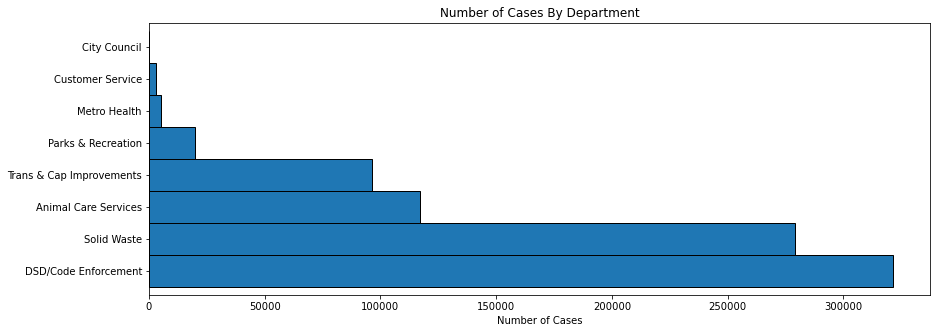

In [2]:
(
    df.groupBy("department")
    .count()
    # then pass to pandas
    .toPandas()
    .set_index("department")["count"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.title("Number of Cases By Department")
plt.ylabel("")
plt.xlabel("Number of Cases")

## 2. Does the percantage of cases that are late vary by department?

In [32]:
# create spark df with necessary info
pct_df = (df.withColumn('case_late', col('case_late').cast('int'))
 .groupby('department')
 .agg(avg('case_late')).alias('pct_cases_late'))

<AxesSubplot:>

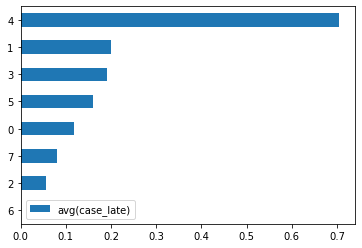

In [41]:
# got a basic image
pct_df.toPandas().sort_values('avg(case_late)', ascending = True).plot.barh()

[Text(0, 0.5, 'Department'),
 Text(0.5, 0, '% Cases Closed After Due Date'),
 Text(0.5, 1.0, '% Late Cases By Department')]

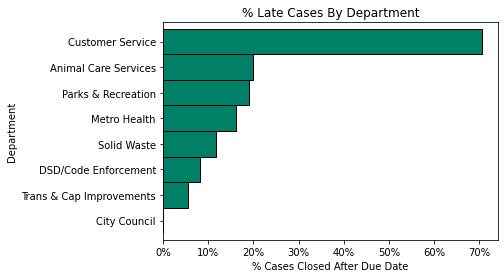

In [120]:
(
    # encode booleans so that it can be counted
    df.withColumn('case_late', col('case_late').cast('int'))
    .groupby('department')
    .agg(avg('case_late').alias('pct_cases_late')) # aggregate the data in spark, rename the column
    .toPandas()
    .set_index('department') 
    .pct_cases_late.sort_values()# sort the pct cases late 
    .plot.barh(width=1, edgecolor='black', cmap = 'summer')
)

plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter("{:.0%}".format))# format numbers to be percentages
plt.gca().set(
    ylabel='Department', xlabel='% Cases Closed After Due Date', title='% Late Cases By Department')# add the labels

#### The percentages of late cases do vary by department

## 3. On average, how late are the late cases by department?

[Text(0, 0.5, 'Department'),
 Text(0.5, 0, 'Days Late'),
 Text(0.5, 1.0, 'Average Days Late by Department')]

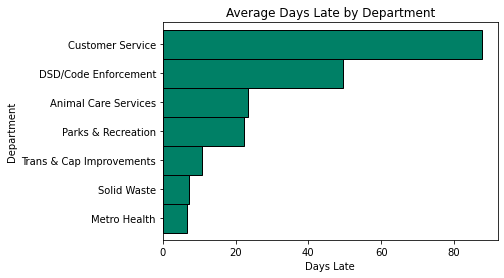

In [60]:
(
df.filter('case_late')
    .groupby('department')
    .agg(avg("num_days_late").alias("avg_days_late"))
    .toPandas()
    .set_index('department')
    .avg_days_late.sort_values()
    .plot.barh(width=1, edgecolor='black', cmap = 'summer')
)
plt.gca().set(
    ylabel='Department', xlabel='Days Late', title='Average Days Late by Department')

## 4. What is the service type that is the most late? Just for Parks & Rec?


[Text(0, 0.5, 'Service Type'),
 Text(0.5, 0, 'Days Late'),
 Text(0.5, 1.0, 'Average Days Late by Service Type')]

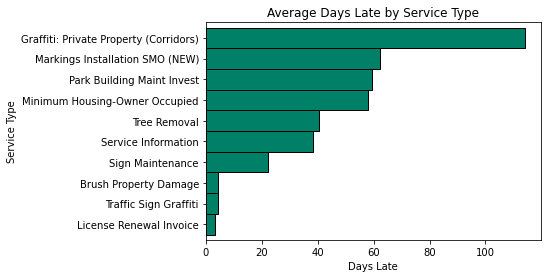

In [77]:
(
df.filter('case_late')
    .groupby('service_request_type')
    .agg(avg("num_days_late").alias("avg_days_late"))
    .limit(10)
    .toPandas()
    .set_index('service_request_type')
    .avg_days_late.sort_values()
    .plot.barh(width=1, edgecolor='black', cmap = 'summer')
)
plt.gca().set(
    ylabel='Service Type', xlabel='Days Late', title='Average Days Late by Service Type')

#### Parks and rec

[Text(0, 0.5, 'Service Type'),
 Text(0.5, 0, 'Days Late'),
 Text(0.5, 1.0, 'Average Days Late for Parks and Rec Service Types')]

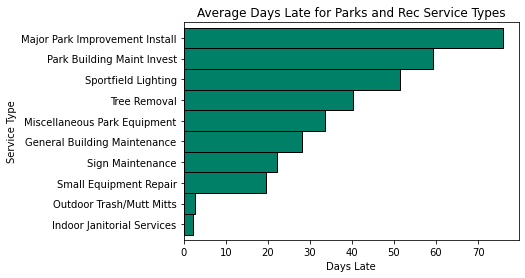

In [78]:
(  
df.filter(df.case_late)
    .filter(df.department == 'Parks & Recreation')
    .groupby('service_request_type')
    .agg(avg("num_days_late").alias("avg_days_late"))
    .limit(10)
    .toPandas()
    .set_index('service_request_type')
    .avg_days_late.sort_values()
    .plot.barh(width=1, edgecolor='black', cmap = 'summer')
)
plt.gca().set(
    ylabel='Service Type', xlabel='Days Late', title='Average Days Late for Parks and Rec Service Types')

## 5. For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

[Text(0, 0.5, 'Service Types'),
 Text(0.5, 0, 'Number of Requests'),
 Text(0.5, 1.0, 'Number of Service Request Types for Code Enforcement')]

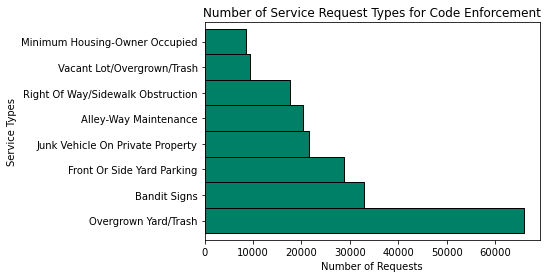

In [94]:
(
    df.filter(expr('department == "DSD/Code Enforcement"'))    
    .groupby("service_request_type")
    .count()
    .sort(desc("count"))
    .limit(8)
    .toPandas()
    .set_index("service_request_type")["count"]
    .plot.barh(width=1, edgecolor='black', cmap = 'summer')
)
#plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter("{:.0}".format)).set_useOffset == False
plt.gca().set(
    ylabel='Service Types', xlabel='Number of Requests', title='Number of Service Request Types for Code Enforcement')

[Text(0, 0.5, 'Service Types'),
 Text(0.5, 0, 'Number of Requests'),
 Text(0.5, 1.0, 'Number of Service Request Types for Customer Service')]

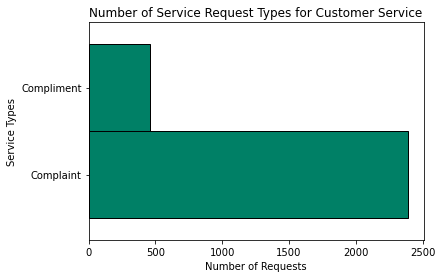

In [96]:
(
    df.filter(expr('department == "Customer Service"'))    
    .groupby("service_request_type")
    .count()
    .sort(desc("count"))
    .limit(8)
    .toPandas()
    .set_index("service_request_type")["count"]
    .plot.barh(width=1, edgecolor='black', cmap = 'summer')
)
plt.gca().set(
    ylabel='Service Types', xlabel='Number of Requests', title='Number of Service Request Types for Customer Service')

[Text(0, 0.5, 'Service Types'),
 Text(0.5, 0, 'Number of Requests'),
 Text(0.5, 1.0, 'Number of Service Request Types for Parks & Recreation')]

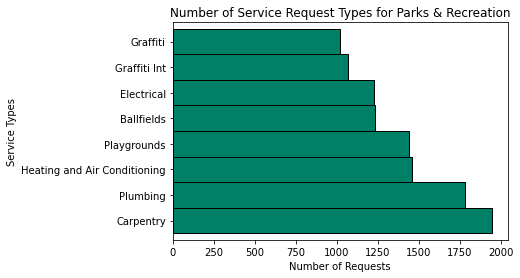

In [97]:
(
    df.filter(expr('department == "Parks & Recreation"'))    
    .groupby("service_request_type")
    .count()
    .sort(desc("count"))
    .limit(8)
    .toPandas()
    .set_index("service_request_type")["count"]
    .plot.barh(width=1, edgecolor='black', cmap = 'summer')
)
#plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter("{:.0}".format)).set_useOffset == False
plt.gca().set(
    ylabel='Service Types', xlabel='Number of Requests', title='Number of Service Request Types for Parks & Recreation')

[Text(0, 0.5, 'Service Types'),
 Text(0.5, 0, 'Number of Requests'),
 Text(0.5, 1.0, 'Number of Service Request Types for Animal Care Services ')]

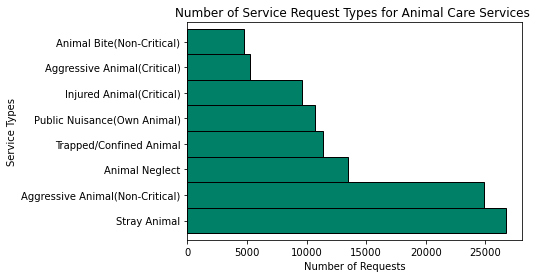

In [98]:
(
    df.filter(expr('department == "Animal Care Services"'))    
    .groupby("service_request_type")
    .count()
    .sort(desc("count"))
    .limit(8)
    .toPandas()
    .set_index("service_request_type")["count"]
    .plot.barh(width=1, edgecolor='black', cmap = 'summer')
)
plt.gca().set(
    ylabel='Service Types', xlabel='Number of Requests', title='Number of Service Request Types for Animal Care Services ')

## 6. Does whether or not its a weekend matter for when a case is opened/closed?

In [104]:
weekdays = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

<AxesSubplot:ylabel='weekday'>

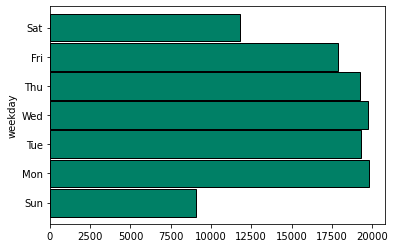

In [109]:
(
    df.filter(expr('department == "Animal Care Services"'))
    .withColumn("weekday", date_format("case_opened_date", "E"))
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    .assign(weekday=lambda df: pd.Categorical(df.weekday, categories=weekdays, ordered=True))
    .set_index("weekday")["count"]
    .sort_index()
    .plot.barh(width=0.95, ec="black", cmap = 'summer')
)

<AxesSubplot:ylabel='weekday'>

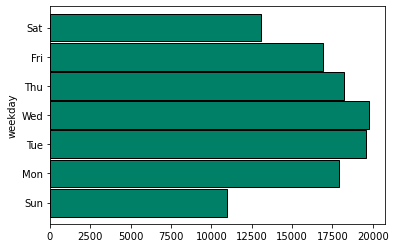

In [111]:
(
    df.filter(expr('department == "Animal Care Services"'))
    .withColumn("weekday", date_format("case_closed_date", "E"))
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    .assign(weekday=lambda df: pd.Categorical(df.weekday, categories=weekdays, ordered=True))
    .set_index("weekday")["count"]
    .sort_index()
    .plot.barh(width=0.95, ec="black", cmap = 'summer')
)

<AxesSubplot:ylabel='weekday'>

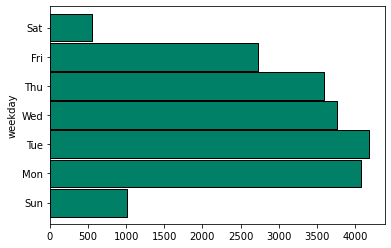

In [112]:
(
    df.filter(expr('department == "Parks & Recreation"'))
    .withColumn("weekday", date_format("case_opened_date", "E"))
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    .assign(weekday=lambda df: pd.Categorical(df.weekday, categories=weekdays, ordered=True))
    .set_index("weekday")["count"]
    .sort_index()
    .plot.barh(width=0.95, ec="black", cmap = 'summer')
)

<AxesSubplot:ylabel='weekday'>

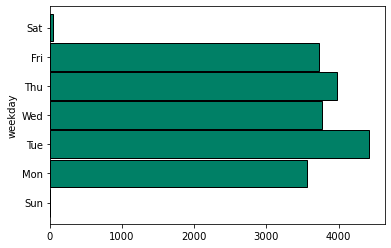

In [113]:
(
    df.filter(expr('department == "Parks & Recreation"'))
    .withColumn("weekday", date_format("case_closed_date", "E"))
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    .assign(weekday=lambda df: pd.Categorical(df.weekday, categories=weekdays, ordered=True))
    .set_index("weekday")["count"]
    .sort_index()
    .plot.barh(width=0.95, ec="black", cmap = 'summer')
)

#### There is a lot more open/closes during the week than the weekend

## 7. On average, how many cases are opened a day for the Customer Service department?

<AxesSubplot:ylabel='weekday'>

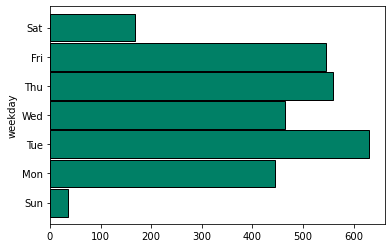

In [118]:
(
    df.filter(expr('department == "Customer Service"'))
    .withColumn("weekday", date_format("case_opened_date", "E"))
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    .assign(weekday=lambda df: pd.Categorical(df.weekday, categories=weekdays, ordered=True))
    .set_index("weekday")["count"]
    .sort_index()
    .plot.barh(width=0.95, ec="black", cmap = 'summer')
)

## 8. Does the number of service requests for the solid waste department vary by day of the week?

<AxesSubplot:ylabel='weekday'>

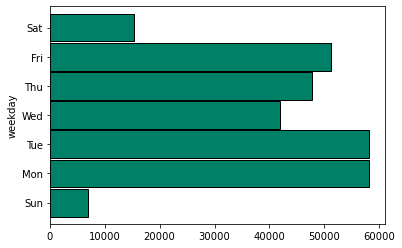

In [119]:
(
    df.filter(expr('department == "Solid Waste"'))
    .withColumn("weekday", date_format("case_opened_date", "E"))
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    .assign(weekday=lambda df: pd.Categorical(df.weekday, categories=weekdays, ordered=True))
    .set_index("weekday")["count"]
    .sort_index()
    .plot.barh(width=0.95, ec="black", cmap = 'summer')
)

#### yes it does, most complaints are during the week with monday and tuesday having the same amounts